# Live Loss Plot with Torchbearer

There is a great tool for visualising training in notebooks called [livelossplot](https://github.com/stared/livelossplot). In this example we will be showing how we can output the quickstart example to livelossplot with torchbearer. 

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed. 



In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer

!pip install livelossplot
print(torchbearer.__version__)


0.4.0.dev


## Loading Data

In exactly the same way as the quickstart guide, we load some data (CIFAR-10) with `torchvision`. The `DatasetValidationSplitter` here lets us get a validation set to work with.

In [2]:
import torch
import torchvision
from torchvision import transforms

from torchbearer.cv_utils import DatasetValidationSplitter

BATCH_SIZE = 128

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

dataset = torchvision.datasets.CIFAR10(root='./data/cifar', train=True, download=True,
                                        transform=transforms.Compose([transforms.ToTensor(), normalize]))
splitter = DatasetValidationSplitter(len(dataset), 0.1)
trainset = splitter.get_train_dataset(dataset)
valset = splitter.get_val_dataset(dataset)

traingen = torch.utils.data.DataLoader(trainset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
valgen = torch.utils.data.DataLoader(valset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)


testset = torchvision.datasets.CIFAR10(root='./data/cifar', train=False, download=True,
                                       transform=transforms.Compose([transforms.ToTensor(), normalize]))
testgen = torch.utils.data.DataLoader(testset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False, num_workers=10)

Files already downloaded and verified
Files already downloaded and verified


## Defining the Model

We now need a model, here's a simple 3 layer strided CNN:

In [3]:
import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 16, stride=2, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, stride=2, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride=2, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.classifier = nn.Linear(576, 10)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, 576)
        return self.classifier(x)


model = SimpleModel()

Training on Cifar10
-------------------------------------

Now we set up the trial with the same parameters as in the quickstart example. We add the LiveLossPlot callback and tell it not to hide the first few epochs. We can then see the figure update as training progresses. Note that we have set verbose=0 since LiveLossPlot clears output often anyway. 

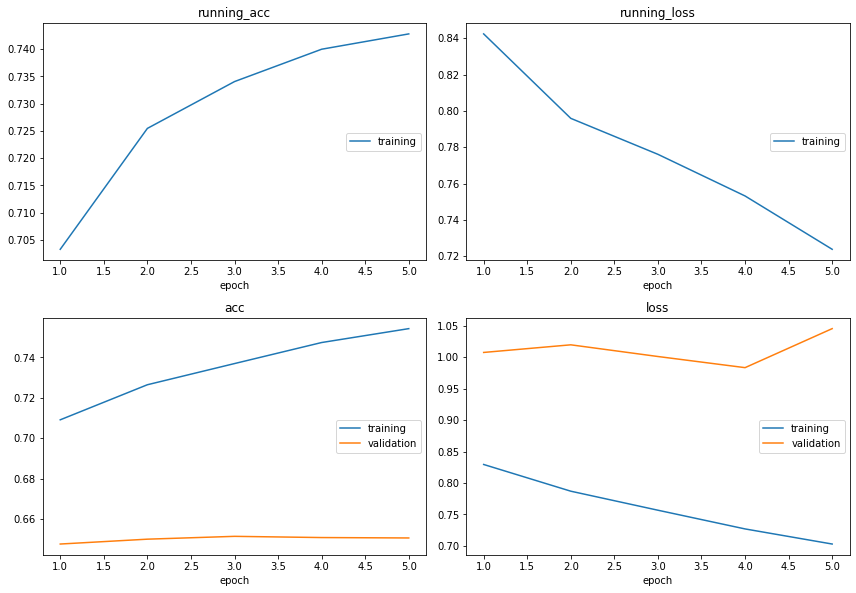

In [6]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = nn.CrossEntropyLoss()

import torchbearer
from torchbearer import Trial
from torchbearer.callbacks import LiveLossPlot

%matplotlib inline
callbacks = [LiveLossPlot(skip_first=0, fig_path="livelossplot.png")]

trial = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=callbacks).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history = trial.run(epochs=5, verbose=0)

We can also get access to the training history of the trial (returned by the run method), if we wanted to do any post analysis. The history is a list with one entry for each epoch. Each entry contains a tuple (num_train_steps, num_val_steps) and the metric dictionary from that epoch.

In [5]:
print(history)

[{'running_acc': 0.5456249713897705, 'running_loss': 1.284641981124878, 'acc': 0.4652000069618225, 'loss': 1.4944727420806885, 'val_acc': 0.5419999957084656, 'val_loss': 1.2637748718261719, 'train_steps': 352, 'validation_steps': 40}, {'running_acc': 0.6014062166213989, 'running_loss': 1.1219536066055298, 'acc': 0.5860666632652283, 'loss': 1.1626864671707153, 'val_acc': 0.5898000001907349, 'val_loss': 1.1585801839828491, 'train_steps': 352, 'validation_steps': 40}, {'running_acc': 0.6479687094688416, 'running_loss': 0.9976592659950256, 'acc': 0.6349555850028992, 'loss': 1.0289160013198853, 'val_acc': 0.6309999823570251, 'val_loss': 1.0630345344543457, 'train_steps': 352, 'validation_steps': 40}, {'running_acc': 0.6753124594688416, 'running_loss': 0.9242058992385864, 'acc': 0.6682222485542297, 'loss': 0.9420693516731262, 'val_acc': 0.6371999979019165, 'val_loss': 1.0390995740890503, 'train_steps': 352, 'validation_steps': 40}, {'running_acc': 0.6942187547683716, 'running_loss': 0.886481